In [67]:
from google.cloud import storage
bucket_name = "team4-project"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
my_prefix='imgs/euro/'
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')
print(blobs)
for blob in blobs:
    print(blob)

<Blob: team4-project, imgs/euro/.DS_Store, 1650537665680586>
<Blob: team4-project, imgs/euro/eval_set.csv, 1650873852574529>
<Blob: team4-project, imgs/euro/full_list.csv, 1650876726663034>
<Blob: team4-project, imgs/euro/train_list.csv, 1650755538061964>
<Blob: team4-project, imgs/euro/train_set.csv, 1650873850559870>
<Blob: team4-project, imgs/euro/val_list.csv, 1650755540087673>


In [68]:
blobs_all = list(bucket.list_blobs(prefix=my_prefix))
gcs_data = []
for x in blobs_all:
    #Select only image files
    if x.name.endswith(('.png','.jpg','.jpeg')):
        gcs_data.append(['gs://'+bucket_name+'/'+x.name,x.name.split('/')[-2]])

In [69]:
import pandas as pd

df = pd.DataFrame(gcs_data)
df2 = df[df[1].isin(['5','10','20','50','100','200','500'])]
print(df2)     
df2.to_csv('text.csv', index = False,header=False)
full_out_path=f'gs://{bucket_name}/{my_prefix}full_list.csv'
!gsutil cp 'text.csv' $full_out_path

                                                     0    1
0     gs://team4-project/imgs/euro/10/10-Euro-back.jpg   10
1          gs://team4-project/imgs/euro/10/10-Euro.jpg   10
2    gs://team4-project/imgs/euro/10/10euro_fr_ES1_...   10
3    gs://team4-project/imgs/euro/10/10euro_re_ES1_...   10
4    gs://team4-project/imgs/euro/10/ECB_10euro_Ban...   10
..                                                 ...  ...
795  gs://team4-project/imgs/euro/500/Screen Shot 2...  500
796  gs://team4-project/imgs/euro/500/Screen Shot 2...  500
797  gs://team4-project/imgs/euro/500/Screen Shot 2...  500
798  gs://team4-project/imgs/euro/500/Screen Shot 2...  500
799  gs://team4-project/imgs/euro/500/Screen Shot 2...  500

[800 rows x 2 columns]
Copying file://text.csv [Content-Type=text/csv]...
/ [1 files][ 45.4 KiB/ 45.4 KiB]                                                
Operation completed over 1 objects/45.4 KiB.                                     


In [70]:
train_data = df2.sample(frac = 0.8)
train_data.to_csv('train_set.csv', index = False,header=False)
train_data_path = f'gs://{bucket_name}/{my_prefix}train_set.csv'
!gsutil cp 'train_set.csv' $train_out_path

# Creating dataframe with
# rest of the 50% values
eval_data = df2.drop(train_data.index)
eval_data.to_csv('eval_set.csv', index = False,header=False)
eval_data_path=f'gs://{bucket_name}/{my_prefix}eval_set.csv'
!gsutil cp 'eval_set.csv' $val_out_path

Copying file://train_set.csv [Content-Type=text/csv]...
/ [1 files][ 36.4 KiB/ 36.4 KiB]                                                
Operation completed over 1 objects/36.4 KiB.                                     
Copying file://eval_set.csv [Content-Type=text/csv]...
/ [1 files][  9.0 KiB/  9.0 KiB]                                                
Operation completed over 1 objects/9.0 KiB.                                      


In [71]:
CLASS_NAMES = df[1].unique()
print(train_data_path)
print(eval_data_path)
print("These are the available classes:", CLASS_NAMES)

gs://team4-project/imgs/euro/train_set.csv
gs://team4-project/imgs/euro/eval_set.csv
These are the available classes: ['10' '100' '20' '200' '5' '50' '500']


In [18]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [81]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      train_data_path).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data_path).
      map(decode_csv)).batch(32) # this doesn't matter

  # train_dataset2 = tf.keras.layers.RandomFlip()(train_dataset)
  #eval_dataset2 = tf.keras.layers.RandomFlip()(eval_dataset2)

  layers = [
     
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.1),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),

      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  # model.build()
  # print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=2)
  training_plot(['loss', 'accuracy'], history)
  return model



In [94]:
def train_and_evaluate2(model,epochs,batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      train_data_path).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data_path).
      map(decode_csv)).batch(32) # this doesn't matter


  layers = [
     
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.1),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),

      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  #model = tf.keras.Sequential(layers, name='flower_classification')
  #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
  #              loss=tf.keras.losses.SparseCategoricalCrossentropy(
  #                  from_logits=False),
  #              metrics=['accuracy'])
  # model.build()
  # print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=epochs)
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/5
20/20 [==============================] - 40s 2s/step - loss: 0.0298 - accuracy: 0.9953 - val_loss: 0.4486 - val_accuracy: 0.9000
Epoch 2/5
20/20 [==============================] - 37s 2s/step - loss: 0.0273 - accuracy: 0.9937 - val_loss: 0.4394 - val_accuracy: 0.9000
Epoch 3/5
20/20 [==============================] - 38s 2s/step - loss: 0.0250 - accuracy: 0.9969 - val_loss: 0.4587 - val_accuracy: 0.8813
Epoch 4/5
20/20 [==============================] - 38s 2s/step - loss: 0.0327 - accuracy: 0.9922 - val_loss: 0.4324 - val_accuracy: 0.8875
Epoch 5/5
20/20 [==============================] - 37s 2s/step - loss: 0.0318 - accuracy: 0.9891 - val_loss: 0.4516 - val_accuracy: 0.8813


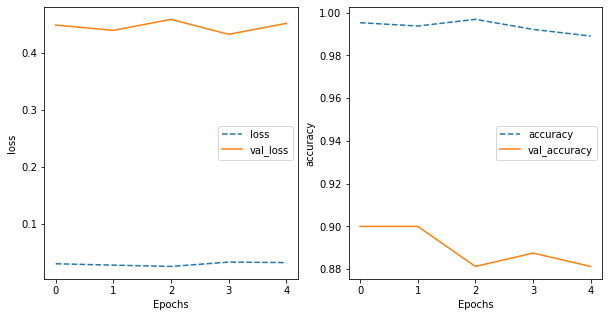

In [107]:
model = train_and_evaluate2(model,5)

In [98]:
model.save(f'gs://{bucket_name}/{my_prefix})

AttributeError: 'str' object has no attribute 'shape'

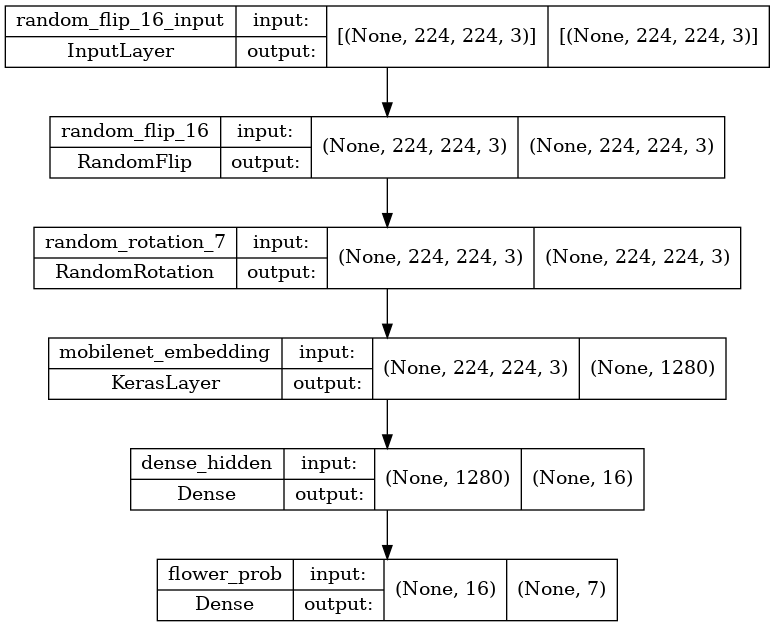

In [82]:
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/30
20/20 [==============================] - 44s 2s/step - loss: 1.6292 - accuracy: 0.4172 - val_loss: 1.3545 - val_accuracy: 0.4812
Epoch 2/30
20/20 [==============================] - 37s 2s/step - loss: 1.2424 - accuracy: 0.5516 - val_loss: 1.1287 - val_accuracy: 0.6062
Epoch 3/30
20/20 [==============================] - 36s 2s/step - loss: 1.0753 - accuracy: 0.6156 - val_loss: 1.0203 - val_accuracy: 0.6625
Epoch 4/30
20/20 [==============================] - 36s 2s/step - loss: 0.9367 - accuracy: 0.6547 - val_loss: 0.9275 - val_accuracy: 0.6750
Epoch 5/30
20/20 [==============================] - 37s 2s/step - loss: 0.8414 - accuracy: 0.6734 - val_loss: 0.8292 - val_accuracy: 0.7000
Epoch 6/30
20/20 [==============================] - 36s 2s/step - loss: 0.7289 - accuracy: 0.7047 - val_loss: 0.7434 - val_accuracy: 0.7312
Epoch 7/30
20/20 [==============================] - 37s 2s/step - loss: 0.6794 - accuracy: 0.7266 - val_loss: 0.6981 - val_accuracy: 0.7500
Epoch 8/30
20/20 [==

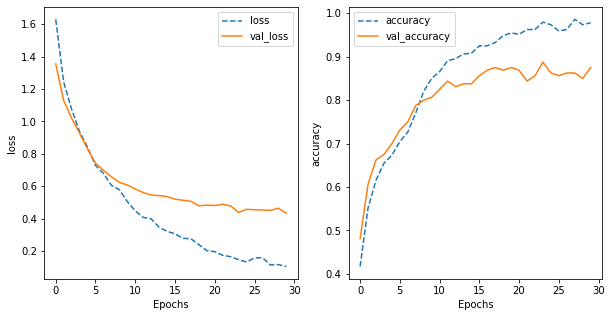

In [83]:
model = train_and_evaluate()

gs://team4-project/imgs/euro/eval_set.csv


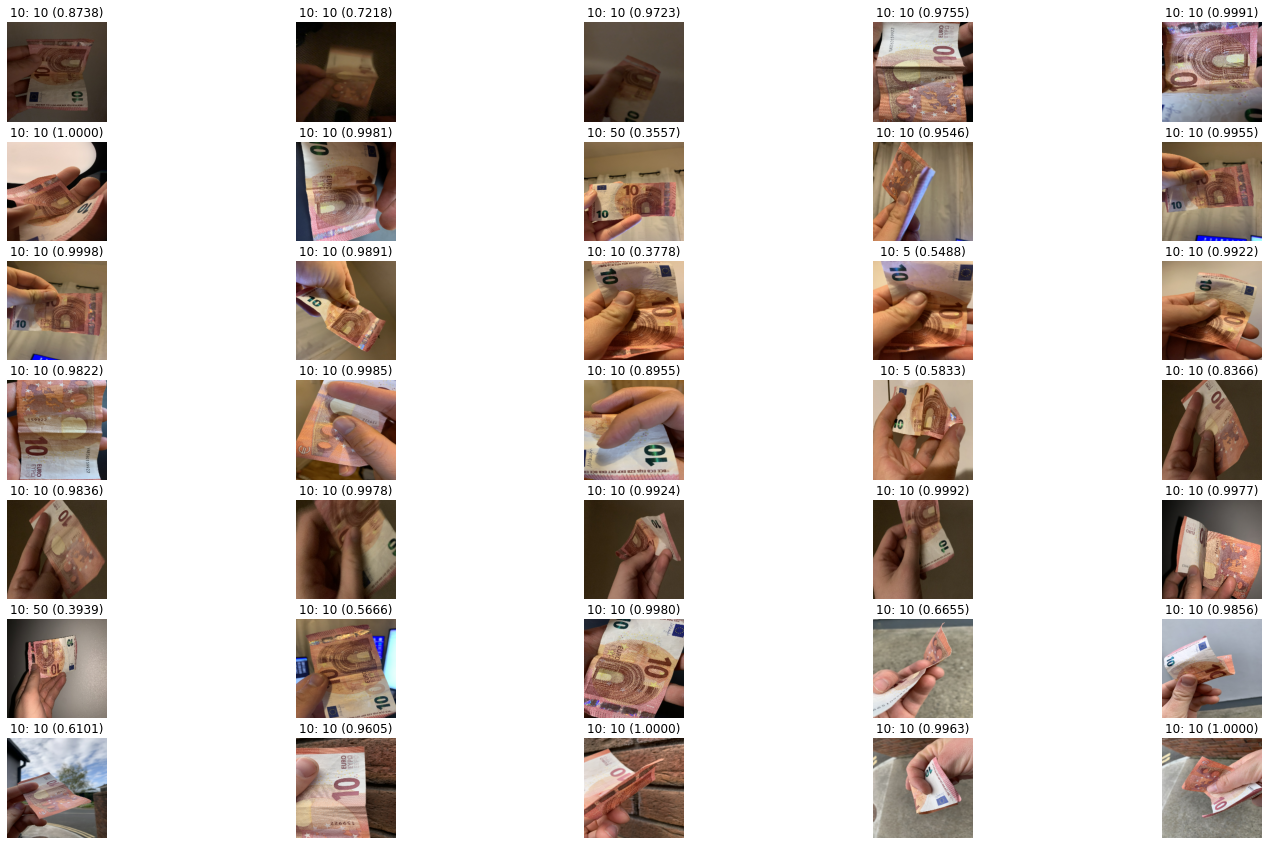

In [84]:
print(eval_data_path)
plot_predictions(model, eval_data_path)

In [104]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [105]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [106]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

INFO:tensorflow:Assets written to: /tmp/tmpqe615xyc/assets


INFO:tensorflow:Assets written to: /tmp/tmpqe615xyc/assets
2022-04-25 11:09:22.169859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-25 11:09:22.169928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-25 11:09:22.170216: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpqe615xyc
2022-04-25 11:09:22.191558: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-25 11:09:22.191618: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpqe615xyc
2022-04-25 11:09:22.281465: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-25 11:09:22.927918: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpqe615xyc
2022-04-25 11:09:23.187515: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

File size: 8740.453 Kilobytes
